In [77]:
# Import Libraries
import pandas as pd
import string, contractions
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import emoji
import pickle

In [78]:
# Import Data
reviews_data_set_path = "/Users/swapnakotha/Desktop/CMPE-257/yelp_dataset/yelp_academic_dataset_review.json"
business_data_set_path = "/Users/swapnakotha/Desktop/CMPE-257/yelp_dataset/yelp_academic_dataset_business.json"


# Dataset is very large(it contains around 6 million reviews). For this analysis, we will only consider the businesses
# in California.

# Get list of businesses in CA.
yelp_businesses = pd.read_json(business_data_set_path, lines=True)
yelp_businesses = pd.DataFrame(yelp_businesses)
yelp_businesses = yelp_businesses.dropna()
yelp_restaurants = yelp_businesses[yelp_businesses['categories'].str.contains("Restaurants")]
yelp_restaurants = yelp_restaurants[['business_id', 'state']]
print(yelp_restaurants.shape[0])

#yelp_ca_restaurants = yelp_restaurants[yelp_restaurants.state == "CA"]
yelp_ca_restaurants = yelp_restaurants
print(yelp_ca_restaurants.shape[0])

44676
44676


In [79]:
# Load all reviews from json
chunk_size = 1000000
yelp_review_chunks = pd.read_json(reviews_data_set_path, lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=chunk_size)

In [80]:
ca_reviews_list = []
count = 0
for review_chunk in yelp_review_chunks:
    review_chunk = review_chunk.drop(['review_id','user_id','date','useful','funny','cool'], axis=1)
    review_chunk = review_chunk.rename(columns={'stars': 'review_stars'})
    review_chunk = review_chunk.rename(columns={'text': 'review_text'})
    #Merge reviews which corresponds to the business in CA.
    ca_review_chunk = pd.merge(yelp_ca_restaurants, review_chunk, on='business_id', how='inner')
    print(f"{ca_review_chunk.shape[0]} out of {chunk_size:,} reviews")
    ca_reviews_list.append(ca_review_chunk)
    count += ca_review_chunk.shape[0]
    # Taking a subset as processing time is very high.
    if count > 1000000:
        break

ca_reviews_df = pd.concat(ca_reviews_list, ignore_index=True, join='outer', axis=0)

666171 out of 1,000,000 reviews
656541 out of 1,000,000 reviews


In [81]:
ca_reviews_df.head()

,business_id,state,review_stars,review_text
0,MTSW4McQd7CbVtyjqoe9mw,PA,4,This is nice little Chinese bakery in the hear...
1,MTSW4McQd7CbVtyjqoe9mw,PA,4,This is the bakery I usually go to in Chinatow...
2,MTSW4McQd7CbVtyjqoe9mw,PA,5,"A delightful find in Chinatown! Very clean, an..."
3,MTSW4McQd7CbVtyjqoe9mw,PA,5,I ordered a graduation cake for my niece and i...
4,MTSW4McQd7CbVtyjqoe9mw,PA,4,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...


In [82]:
ca_reviews_df = ca_reviews_df[['review_text', 'review_stars']]
ca_reviews_df.head()

,review_text,review_stars
0,This is nice little Chinese bakery in the hear...,4
1,This is the bakery I usually go to in Chinatow...,4
2,"A delightful find in Chinatown! Very clean, an...",5
3,I ordered a graduation cake for my niece and i...,5
4,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...,4


In [83]:
ca_reviews_df.isna().mean()

review_text     0.0
review_stars    0.0
dtype: float64

In [84]:
ca_reviews_df = ca_reviews_df.head(1000000)

In [85]:
print(ca_reviews_df.shape[0])

1000000


In [86]:
# Assign labels to each review. Positive as 2, Neutral as 1, Negative as 0.
#ca_reviews_df['review_labels'] = ca_reviews_df['review_stars'].apply(lambda x:0 if x<3 else (1 if x==3 else 2))

# Assign labels to each review. Positive as 1, Negative as 0.
ca_reviews_df['review_binary_labels'] = ca_reviews_df['review_stars'].apply(lambda x:0 if x<3 else 1)

ca_reviews_df.head()

,review_text,review_stars,review_binary_labels
0,This is nice little Chinese bakery in the hear...,4,1
1,This is the bakery I usually go to in Chinatow...,4,1
2,"A delightful find in Chinatown! Very clean, an...",5,1
3,I ordered a graduation cake for my niece and i...,5,1
4,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...,4,1


In [87]:
# Create training data set & test data set from dataframe
def get_training_and_test_data(ca_reviews_df, label):
    reviews_training_data, reviews_test_data = train_test_split(ca_reviews_df, test_size = 0.3, stratify = ca_reviews_df[label], random_state = 42)
    y_reviews_training_labels = reviews_training_data[label].values
    y_reviews_test_labels = reviews_test_data[label].values
    return reviews_training_data, y_reviews_training_labels, reviews_test_data, y_reviews_test_labels

def pre_process_review(review):
    tokens = []
    
    # lower case the review string
    review = review.lower()
    
    # split the review into individual tokens
    review_token_list = review.split()
    
    # Removing contractions and punctuation from token
    for review_token in review_token_list:
        review_token = contractions.fix(review_token)
        review_token = review_token.translate(str.maketrans('','',string.punctuation))
        for token in review_token.split():
            tokens.append(token)

    return tokens


In [88]:
# Perform Analysis with 2 labels (Positive or Negative) with in-built analyzer

reviews_training_data, y_reviews_training_labels, reviews_test_data, y_reviews_test_labels = get_training_and_test_data(ca_reviews_df, 'review_binary_labels')

# Perform Vectorization on the review text
vectorize_reviews = CountVectorizer(binary=True, min_df = 10, max_df = 0.95, ngram_range=(1,2))
vectorize_reviews.fit_transform(reviews_training_data['review_text'].values)

reviews_training_features = vectorize_reviews.transform(reviews_training_data['review_text'].values)
reviews_test_features = vectorize_reviews.transform(reviews_test_data['review_text'].values)

In [89]:
# Run Logistic Regression
logistic_regression = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
logistic_regression.fit(reviews_training_features,y_reviews_training_labels)
y_reviews_predicted_labels = logistic_regression.predict(reviews_test_features)

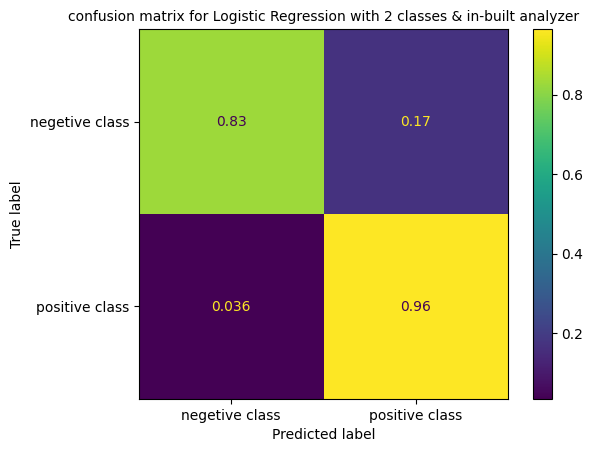

In [90]:
disp = ConfusionMatrixDisplay.from_predictions(y_reviews_test_labels, y_reviews_predicted_labels,
                                               normalize='true',
                                               display_labels=['negetive class', 'positive class'])
disp.ax_.set_title('confusion matrix for Logistic Regression with 2 classes & in-built analyzer',fontsize = 10);
plt.show()



In [91]:
# Calculate Accuracy & F1 Score
print("Accuracy for the Logistic Regression model: ",round(metrics.accuracy_score(y_reviews_test_labels,y_reviews_predicted_labels),3))
print("F1 for the Logistic Regression model: ",round(metrics.f1_score(y_reviews_test_labels, y_reviews_predicted_labels, average='weighted'),3))

Accuracy for the Logistic Regression model:  0.937
F1 for the Logistic Regression model:  0.937


In [92]:
from sklearn.metrics import classification_report
print(classification_report(y_reviews_test_labels,y_reviews_predicted_labels ))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84     60022
           1       0.96      0.96      0.96    239978

    accuracy                           0.94    300000
   macro avg       0.91      0.90      0.90    300000
weighted avg       0.94      0.94      0.94    300000



In [115]:


test_review = vectorize_reviews.transform(["Super slow service,salads are not good"])
output=logistic_regression.predict_proba(test_review)

negative=round(output[0][0],3)
positive=round(output[0][1],3)
print("TEST review-Super slow service,salads are not good")
print("Proability that test review is positive is "+ str(positive))
print("Proability that test review is negative is "+ str(negative))
if(logistic_regression.predict(test_review)==0):
    print('Over all the review is negative '+ emoji.emojize(':thumbs_down:') )
    
else:
    print("Over all the review is positive " + emoji.emojize(':thumbs_up:'))

TEST review-Super slow service,salads are not good
Proability that test review is positive is 0.134
Proability that test review is negative is 0.866
Over all the review is negative 👎


In [116]:
test_review = vectorize_reviews.transform(["Their brunch is awesome, I love the avocado toast and the California focaccia. Pizza is really good as well"])
output=logistic_regression.predict_proba(test_review)

negative=round(output[0][0],3)
positive=round(output[0][1],3)
print("TEST review-Their brunch is awesome, I love the avocado toast and the California focaccia. Pizza is really good as well")
print("Proability that test review is positive is "+ str(positive))
print("Proability that test review is negative is "+ str(negative))
if(logistic_regression.predict(test_review)==0):
    print('Over all the review is negative '+ emoji.emojize(':thumbs_down:') )
    
else:
    print("Over all the review is positive " + emoji.emojize(':thumbs_up:'))

TEST review-Their brunch is awesome, I love the avocado toast and the California focaccia. Pizza is really good as well
Proability that test review is positive is 0.999
Proability that test review is negative is 0.001
Over all the review is positive 👍


In [117]:
import pickle
filename = 'finalized_model_logistic _regression.sav'
pickle.dump(logistic_regression, open(filename, 'wb'))

In [31]:
#load the model
filename = 'finalized_model_logistic _regression.sav'
logistic_regression = pickle.load(open(filename, 'rb'))
test_review1 = vectorize_reviews.transform(["Super slow service,salads are not good."])
output1=logistic_regression.predict_proba(test_review1)
negative1=round(output1[0][0],3)
positive1=round(output1[0][1],3)
print("Proability that test review is positive is "+ str(positive1))
print("Proability that test review is negative is "+ str(negative1))

Proability that test review is positive is 0.134
Proability that test review is negative is 0.866


In [141]:
words_effect_on_sentiment= logistic_regression.coef_[0][:20]
words_effect_on_sentiment =logistic_regression.coef_[0]
import numpy as np
increacing_effects = np.argsort(words_effect_on_sentiment)
top_most_effected_words_pos = [list(vectorize_reviews.vocabulary_.keys())[list(vectorize_reviews.vocabulary_.values()).index(w)] for w in increacing_effects[range(-1,-21, -1)]]
print(top_most_effected_words_pos)

['three stars', 'not disappointed', 'never disappointed', 'superb', 'star off', 'wasn disappointed', 'delicious', 'be disappointed', 'three because', 'heaven', 'even better', 'three star', 'excellent', 'yum', 'best', 'fantastic', 'awesome', 'perfection', 'amazing', 'never disappoints']


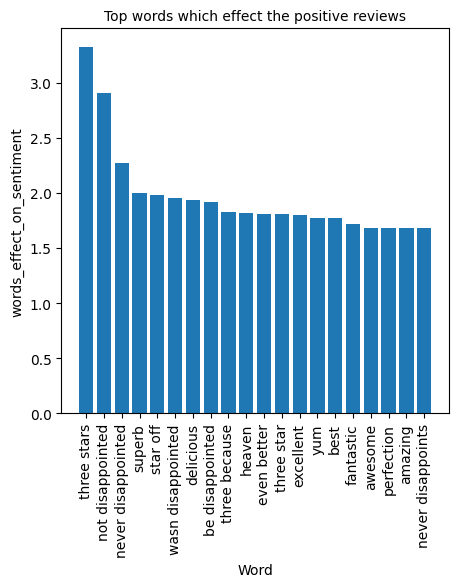

In [142]:

fig = plt.figure(figsize=(5, 5))
ax = plt.bar(top_most_effected_words_pos, words_effect_on_sentiment[increacing_effects[range(-1,-21, -1)]])
plt.title("Top words which effect the positive reviews",fontsize = 10)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.ylabel('words_effect_on_sentiment', fontsize = 10)
plt.xlabel('Word', fontsize = 10);






In [120]:
top_most_effected_words_neg = [list(vectorize_reviews.vocabulary_.keys())[list(vectorize_reviews.vocabulary_.values()).index(w)] for w in increacing_effects[:20]]
print(top_most_effected_words_neg)

['two stars', 'worst', 'experienced better', 'never coming', 'never again', 'at best', 'pathetic', 'wouldn try', 'zero stars', 'horrible', 'cockroach', 'never going', 'not recommend', 'not dinner', 'not worth', 'slowest', 'second star', 'no stars', 'were priced', 'roach']


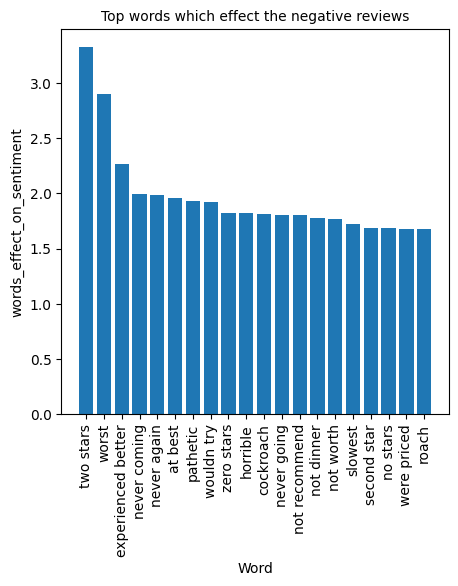

In [121]:
fig = plt.figure(figsize=(5, 5))
ax = plt.bar(top_most_effected_words_neg, words_effect_on_sentiment[increacing_effects[range(-1,-21, -1)]])
plt.title("Top words which effect the negative reviews",fontsize = 10)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.ylabel('words_effect_on_sentiment', fontsize = 10)
plt.xlabel('Word', fontsize = 10);

In [58]:
#Adding three class sentiment analysis

In [61]:
ca_reviews_df = ca_reviews_df[['review_text', 'review_stars']]
ca_reviews_df.head()

,review_text,review_stars
0,This is nice little Chinese bakery in the hear...,4
1,This is the bakery I usually go to in Chinatow...,4
2,"A delightful find in Chinatown! Very clean, an...",5
3,I ordered a graduation cake for my niece and i...,5
4,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...,4


In [62]:
ca_reviews_df['review_labels'] = ca_reviews_df['review_stars'].apply(lambda x:0 if x<3 else (1 if x==3 else 2))

In [63]:
ca_reviews_df.head()

,review_text,review_stars,review_labels
0,This is nice little Chinese bakery in the hear...,4,2
1,This is the bakery I usually go to in Chinatow...,4,2
2,"A delightful find in Chinatown! Very clean, an...",5,2
3,I ordered a graduation cake for my niece and i...,5,2
4,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...,4,2


In [66]:
reviews_training_data, y_reviews_training_labels, reviews_test_data, y_reviews_test_labels = get_training_and_test_data(ca_reviews_df, 'review_labels')

# Perform Vectorization on the review text
vectorize_reviews = CountVectorizer(analyzer = pre_process_review, min_df = 10, max_df = 0.95, ngram_range=(1,2))
vectorize_reviews.fit_transform(reviews_training_data['review_text'].values)

reviews_training_features = vectorize_reviews.transform(reviews_training_data['review_text'].values)
reviews_test_features = vectorize_reviews.transform(reviews_test_data['review_text'].values)


In [67]:
logistic_regression = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter=1000)
logistic_regression.fit(reviews_training_features,y_reviews_training_labels)
y_reviews_predicted_labels = logistic_regression.predict(reviews_test_features)

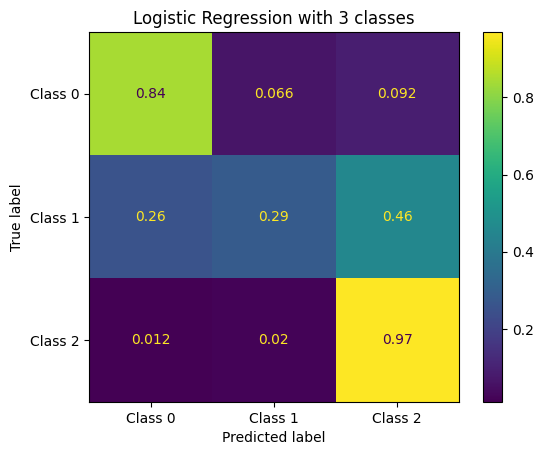

Accuracy:  0.866
F1:  0.851


In [68]:
disp = ConfusionMatrixDisplay.from_predictions(y_reviews_test_labels, y_reviews_predicted_labels,
                                               normalize='true',
                                               display_labels=['Class 0', 'Class 1', 'Class 2'])
disp.ax_.set_title('Logistic Regression with 3 classes');
plt.show()

# Calculate Accuracy & F1 Score
print("Accuracy: ",round(metrics.accuracy_score(y_reviews_test_labels,y_reviews_predicted_labels),3))
print("F1: ",round(metrics.f1_score(y_reviews_test_labels, y_reviews_predicted_labels, average='weighted'),3))

In [69]:
test_review = vectorize_reviews.transform(["I ordered the Stone Pot Rice Bowl with Beef. There was not more than one teaspoon of beef in the entire meal. Just a big pile of rice. Very disappointing for $18"])
output=logistic_regression.predict_proba(test_review)

negative=round(output[0][0],3)
neutral=round(output[0][1],3)
positive=round(output[0][2],3)
print("Proability that test review is positive is "+ str(positive))
print("Proability that test review is neutral is "+ str(neutral))
print("Proability that test review is negative is "+ str(negative))

Proability that test review is positive is 0.078
Proability that test review is neutral is 0.103
Proability that test review is negative is 0.819


In [ ]:
reviews_training_data, y_reviews_training_labels, reviews_test_data, y_reviews_test_labels = get_training_and_test_data(ca_reviews_df, 'review_binary_labels')

# Perform Vectorization on the review text
vectorize_reviews = CountVectorizer(binary=True, min_df = 10, max_df = 0.95, ngram_range=(1,2))
vectorize_reviews.fit_transform(reviews_training_data['review_text'].values)

reviews_training_features = vectorize_reviews.transform(reviews_training_data['review_text'].values)
reviews_test_features = vectorize_reviews.transform(reviews_test_data['review_text'].values)